# Notebook for training squeezenet network for image classification based on membrane signal
Adapted from Pytorch library: https://pytorch.org/

In [7]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.utils.data.sampler import WeightedRandomSampler
from torch.optim import lr_scheduler
import os
import copy
import time
import matplotlib.pyplot as plt
from PIL import Image
import random
import pandas
import glob
from tqdm.notebook import tqdm
import shutil

### Prepare data

In [2]:
# Path to training and validation datasets
data_dir = 'Example_dataset'

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation

data_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(3),
        transforms.Resize(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Grayscale(3),
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0")# if torch.cuda.is_available() else "cpu")

/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc)

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'valid':
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best valid Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss_history, train_acc_history, val_loss_history, val_acc_history

In [5]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['valid']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}' + ' -- ' + f'true: {class_names[labels[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

### Train model

In [6]:
model_ft = models.squeezenet1_0(pretrained=True)
num_classes = 2
model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
model_ft.num_classes = num_classes

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=25, gamma=0.1)

In [7]:
model_ft, train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=80)

Epoch 0/79
----------


/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1153.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train Loss: 0.5558 Acc: 0.6983
valid Loss: 0.3431 Acc: 0.8770

Epoch 1/79
----------
train Loss: 0.5079 Acc: 0.7544
valid Loss: 0.2917 Acc: 0.8812

Epoch 2/79
----------
train Loss: 0.4868 Acc: 0.7513
valid Loss: 0.3019 Acc: 0.8686

Epoch 3/79
----------
train Loss: 0.3915 Acc: 0.8207
valid Loss: 0.3204 Acc: 0.8454

Epoch 4/79
----------
train Loss: 0.3620 Acc: 0.8318
valid Loss: 0.2626 Acc: 0.8875

Epoch 5/79
----------
train Loss: 0.3315 Acc: 0.8554
valid Loss: 0.2415 Acc: 0.8991

Epoch 6/79
----------
train Loss: 0.3079 Acc: 0.8577
valid Loss: 0.2700 Acc: 0.8833

Epoch 7/79
----------
train Loss: 0.2946 Acc: 0.8726
valid Loss: 0.2240 Acc: 0.9022

Epoch 8/79
----------
train Loss: 0.2769 Acc: 0.8808
valid Loss: 0.2290 Acc: 0.8980

Epoch 9/79
----------
train Loss: 0.2913 Acc: 0.8734
valid Loss: 0.2469 Acc: 0.9033

Epoch 10/79
----------
train Loss: 0.2670 Acc: 0.8829
valid Loss: 0.2011 Acc: 0.9085

Epoch 11/79
----------
train Loss: 0.2918 Acc: 0.8768
valid Loss: 0.2109 Acc: 0.9106



### Save model

In [16]:
MODEL_SAVE_PATH = 'trained_networks'
modelname = 'CD45_trained_model_squeezenet'
torch.save(model_ft.state_dict(), os.path.join(MODEL_SAVE_PATH, modelname))

### Training results

In [17]:
train_acc_history_float = [float(q) for q in train_acc_history]
val_acc_history_float = [float(q) for q in val_acc_history]

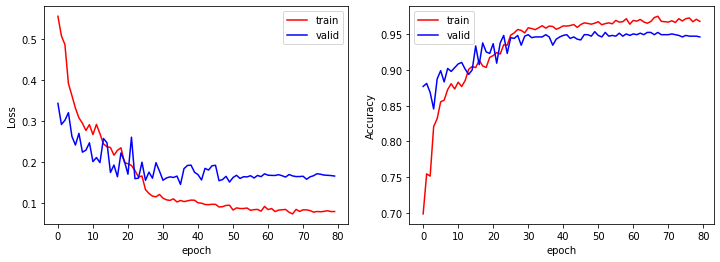

In [19]:
fig, ax = plt.subplots(1,2, figsize = (12,4))

ax[0].plot(train_loss_history, color = 'red', label = 'train')
ax[0].plot(val_loss_history, color = 'blue', label = 'valid')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('Loss')

ax[1].plot(train_acc_history_float, color = 'red', label = 'train')
ax[1].plot(val_acc_history_float, color = 'blue', label = 'valid')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('Accuracy')

ax[0].legend()
ax[1].legend()

plt.show()

/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


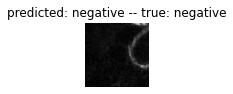

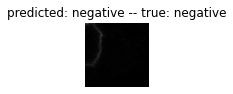

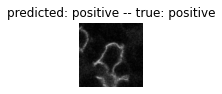

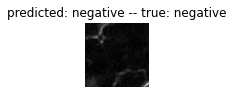

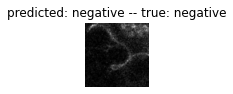

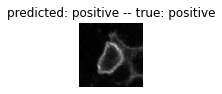

In [21]:
visualize_model(model_ft, num_images=6)

### Confusion matrix

In [7]:
nb_classes = 2
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

confusion_matrix = torch.zeros(nb_classes, nb_classes)

with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['valid']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_load(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
print(confusion_matrix)

/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1153.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


tensor([[576.,  11.],
        [ 40., 324.]])
